In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.signal import find_peaks
# from scipy import 
import datetime

In [2]:
# scp algaemist@adls:projects/algaemist-project/algaemist_project/experiment/main_experiment.csv .\algaemist_project\data\exp_data.csv

In [3]:
path = 'exp_data.csv'

exp_data = pd.read_csv(path)

In [4]:
exp_data['timestamp'] = pd.to_datetime(exp_data['timestamp'])
exp_data['delta_min'] = ((exp_data['timestamp']-exp_data['timestamp'].shift()).dt.total_seconds()/60).fillna(0)
exp_data['total_runtime_min'] = exp_data['delta_min'].cumsum()
exp_data['total_runtime_hour'] = exp_data['total_runtime_min']/60
exp_data['temp_change'] = np.where(exp_data['comments'].str.startswith('Temp', na=False), 1,0)
exp_data['exp_temp'] = 15 + exp_data['temp_change'].cumsum()
exp_data['end'] = np.where(exp_data['comments'] == 'end', 1, 0)
exp_data['start'] = np.where(exp_data['comments'] == 'Turb set to 270', 1, 0)

In [35]:
exp_data.info

<bound method DataFrame.info of                timestamp   temp    pH  light_prim  light_sec     air   co2  \
0    2025-11-10 13:42:59  18.32  7.69        64.0       90.0  261.27  5.67   
1    2025-11-10 13:43:00  18.32  7.69        64.0       90.0  261.27  5.67   
2    2025-11-10 13:43:01  18.30  7.69        65.0       90.0  260.18  5.67   
3    2025-11-10 13:48:30  18.42  7.60        64.0       93.0  261.27  3.03   
4    2025-11-10 13:48:31  18.42  7.60        64.0       93.0  261.27  3.03   
...                  ...    ...   ...         ...        ...     ...   ...   
1340 2025-11-22 07:40:21  38.13  8.23       233.0      288.0  273.55  3.14   
1341 2025-11-22 07:55:22  37.55  8.26       234.0      279.0  273.55  4.80   
1342 2025-11-22 08:10:22  37.23  8.35       233.0      271.0  273.55  3.03   
1343 2025-11-22 08:19:37  37.31  8.35       234.0      270.0  273.55  3.03   
1344 2025-11-22 08:25:22  38.07  8.20       233.0      269.0  274.70  3.70   

      heater_pump  cooler_pump 

In [5]:
idcs = exp_data.iloc[5:][exp_data['temp_change'] > 0].index


C:\Users\Yassin\AppData\Local\Temp\ipykernel_33664\4043224428.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  idcs = exp_data.iloc[5:][exp_data['temp_change'] > 0].index


In [6]:
interval = exp_data.iloc[idcs]['total_runtime_hour'].to_list()

In [7]:
las_idx = exp_data['total_runtime_hour'].iloc[-1]

In [8]:
interval.append(las_idx)

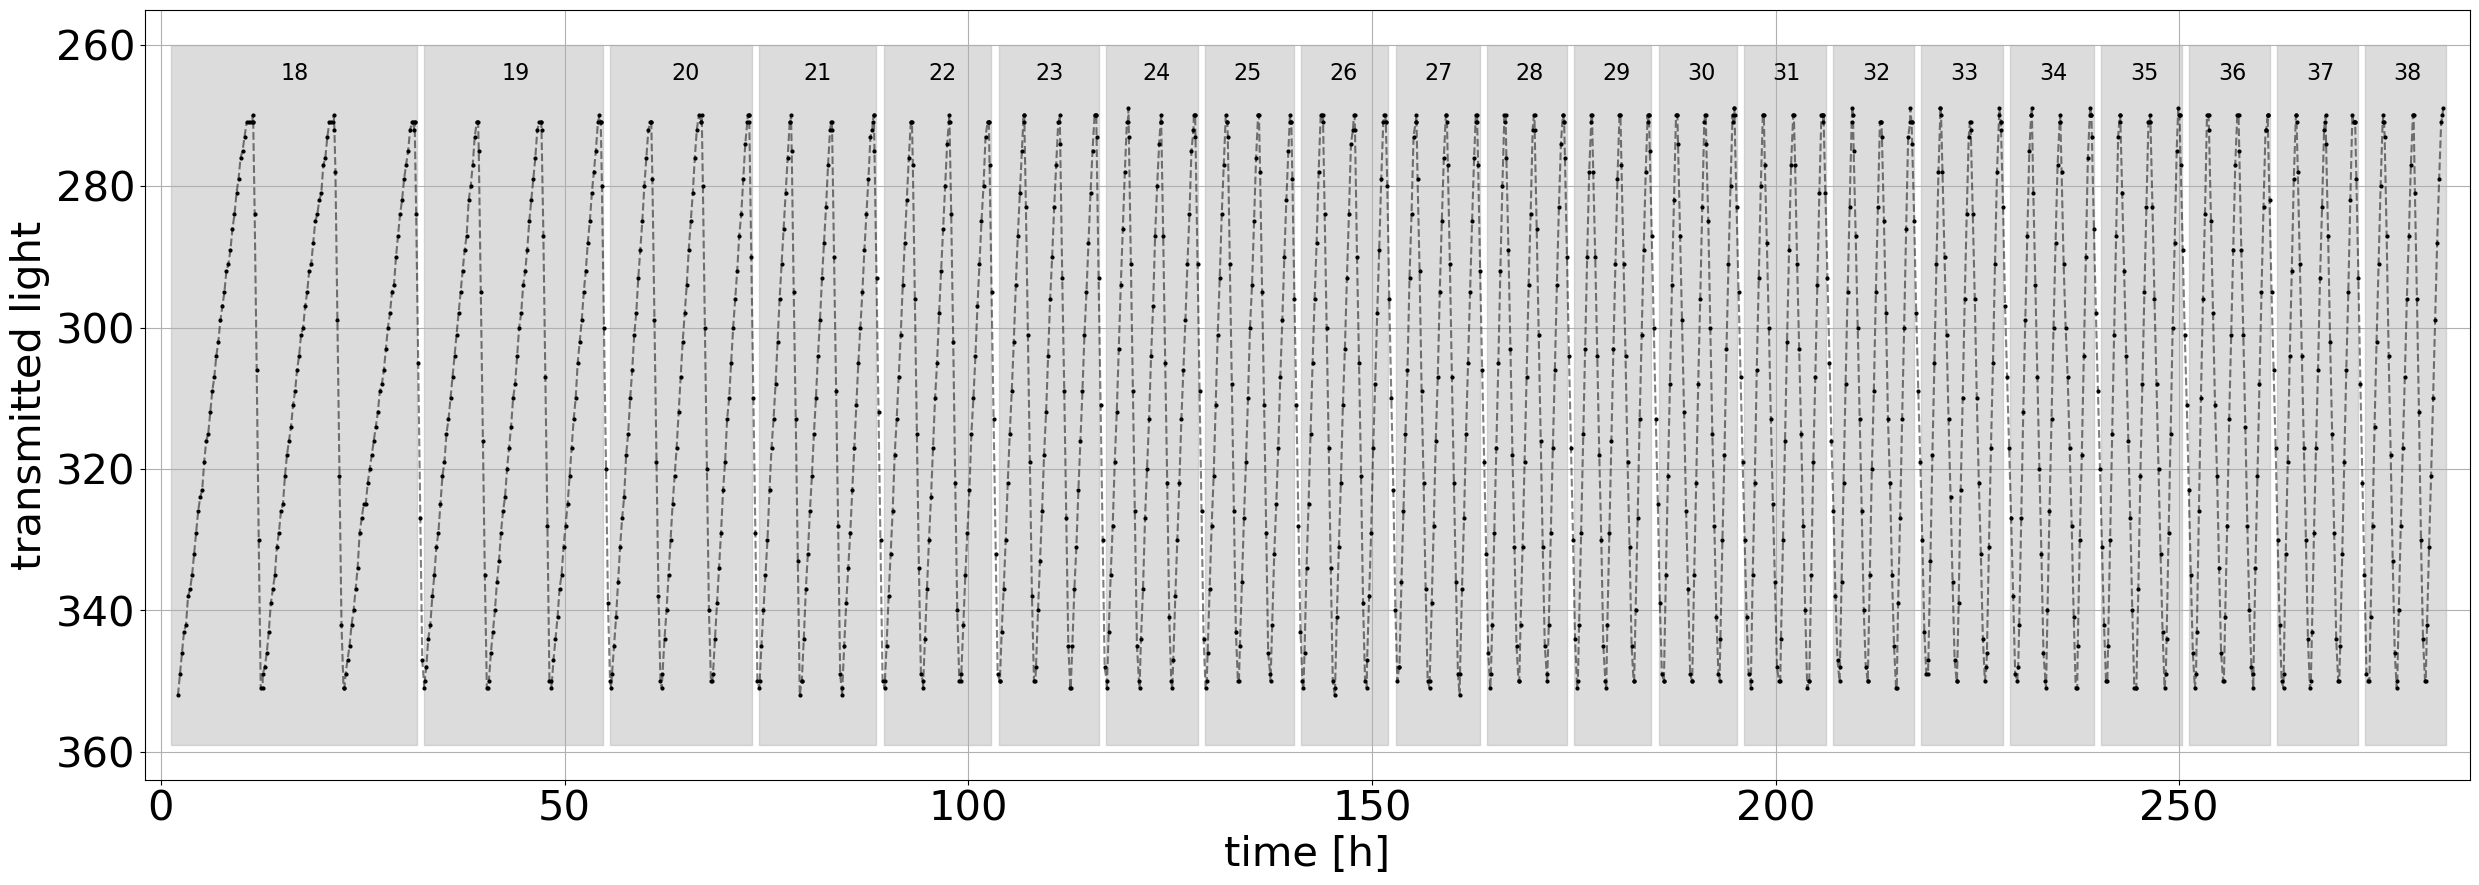

In [9]:
ys = np.arange(260, 360)

fig, ax = plt.subplots(figsize=(30,10))

for i in range(len(interval)-1):
    ax.fill_betweenx(ys, interval[i]+1.2, interval[i+1]+.3, alpha=.4, color='darkgrey')
    ax.text((interval[i]+((interval[i+1] - interval[i])//2)+1.5), 265, i+18, ha='center', fontsize=16)
# sns.scatterplot(x=exp_data['total_runtime_hour'][15:], y=exp_data['light_sec'][15:], ax=ax, size=.2, color='k')
ax.plot(exp_data['total_runtime_hour'][15:], exp_data['light_sec'][15:], 'k--', alpha=.5)
ax.plot(exp_data['total_runtime_hour'][15:], exp_data['light_sec'][15:], 'k.',markersize=4)
    
ax.set_ylabel('transmitted light', fontsize=30)
ax.set_xlabel('time [h]', fontsize=30)
ax.xaxis.set_tick_params(labelsize=30)
ax.yaxis.set_tick_params(labelsize=30)
ax.invert_yaxis()
ax.grid()
ax.set_xlim(-2,286)
# ax.legend(bbox_to_anchor=(1.01, 0.99), title='temperature')
plt.show()

In [10]:
startpts = exp_data[exp_data['start'] == 1].index
endpts = exp_data[exp_data['end'] == 1].index

In [11]:
growth_intervall = []
for i in range(len(endpts)):
    growth_data = exp_data.iloc[startpts[i]:endpts[i]]
    growth_intervall.append(growth_data)

growth_curves = {}
for j in range(len(growth_intervall)):    
    table = growth_intervall[j]
    # s = [i * 300 /60 for i in range(len(table['timestamp']))] 
    # x = [i for i in range(startpts[j],endpts[j])]
    x = table['total_runtime_hour'].values 
    y = table['light_sec']
    slope, intercept = np.polyfit(x, y, 1)
    f = np.poly1d((slope, intercept))
    ys = f(x)
    growth_curves[j] = [x, ys, slope, intercept]
    
len(growth_curves)

63

In [12]:
growth_time = []
for j in growth_intervall:
    delta= j.iloc[-1].timestamp - j.iloc[0].timestamp
    growth_time.append(delta.total_seconds() / 3600)  
    
mean_growth_times = []
sd_growth_times   = []
sem_growth_times  = []

for i in range(0, len(growth_time), 3):
    group = growth_time[i:i+3]          # 3 replicates
    mean_growth_times.append(np.mean(group))
    sd_growth_times.append(np.std(group, ddof=1))     # sample SD
    sem_growth_times.append(sd_growth_times[-1] / np.sqrt(3))  # SEM

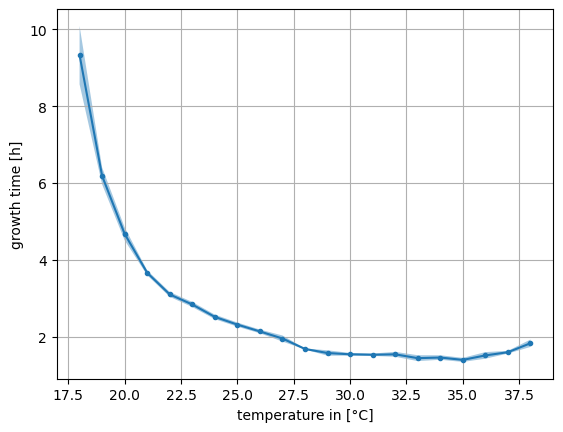

In [13]:
fig, ax = plt.subplots()

ax.fill_between([x +18 for x in range(len(mean_growth_times))],
                [mean_growth_times[i]-sem_growth_times[i] for i in range(len(mean_growth_times))],
                [mean_growth_times[i]+sem_growth_times[i] for i in range(len(mean_growth_times))],
                alpha=0.4,
                label='SEM')
ax.plot([x +18 for x in range(len(mean_growth_times))], mean_growth_times, '.-')


ax.set_ylabel('growth time [h]')
ax.set_xlabel('temperature in [°C]')
plt.grid()
plt.show()

# ax.errorbar([x +18 for x in range(len(mean_growth_times))],
#             mean_growth_times,
#             yerr=sem_growth_times,
#             markersize=4,
#             fmt='o', 
#             capsize=5, 
#             color='blue', 
#             ecolor='black', 
#             label='Mean ± SD')

In [14]:
mean_growth_times

[9.331388888888888,
 6.185185185185186,
 4.6752777777777785,
 3.661481481481481,
 3.0986111111111114,
 2.8362962962962963,
 2.5130555555555554,
 2.312314814814815,
 2.1341666666666668,
 1.950185185185185,
 1.6777777777777778,
 1.5721296296296297,
 1.5387962962962964,
 1.5275925925925924,
 1.5385185185185186,
 1.438425925925926,
 1.455,
 1.3935185185185184,
 1.5103703703703701,
 1.5936111111111113,
 1.827037037037037]

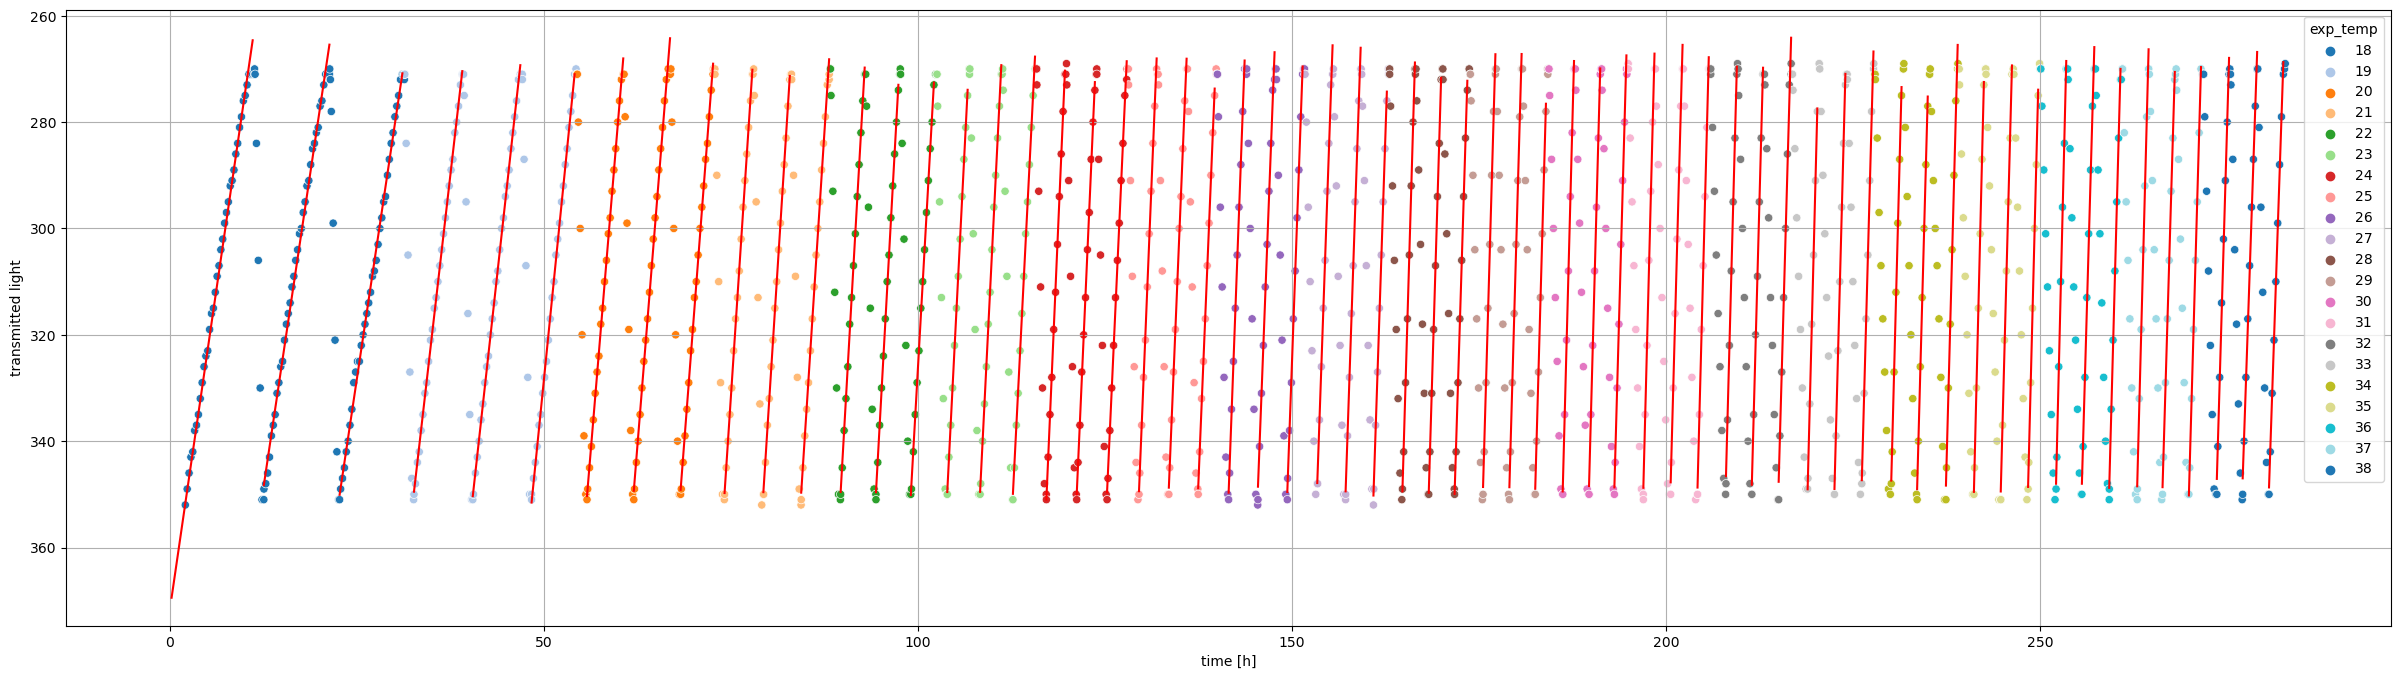

In [15]:
fig, ax = plt.subplots(figsize=(30,8))

# ax.plot(exp_data['total_runtime_hour'][15:], exp_data['light_sec'][15:], 'k--', alpha=.5)
for k in range(len(growth_curves)):
    ax.plot(growth_curves[k][0],growth_curves[k][1], 'r')
    # ax.text(exp_data['total_runtime_hour'].iloc[growth_curves[k][0][0]], 94, f'slope :{growth_curves[k][2]:.2f}\ninter: {growth_curves[k][3]:.2f}', color='red')
sns.scatterplot(x=exp_data['total_runtime_hour'][15:], y=exp_data['light_sec'][15:], hue=exp_data[15:]['exp_temp'], ax=ax, palette='tab20')
ax.set_ylabel('transmitted light')
ax.set_xlabel('time [h]')
ax.invert_yaxis()
ax.grid()
# ax.legend(bbox_to_anchor=(1.25, 0.99), title='temperature')
# ax.set_xlim(160,180)
plt.show()
# 

In [16]:

[85,
101,
99,
119,
135,
140]


[85, 101, 99, 119, 135, 140]

In [17]:
culture_den = pd.DataFrame({'light_sec': [64, 280, 290, 310, 330, 350],
                            'cell_count' : [100,100,100,100,100,100],
                            'squares' : [85, 101, 99, 119, 135, 140],
                            'dilution' : [16,8,8,8,8,8]})



In [18]:
culture_den['cells_psq'] = culture_den['cell_count'] /culture_den['squares']
culture_den['cells_ml'] = culture_den['cells_psq'] *4*1000*1000
culture_den['orig_den_ml'] = culture_den['cells_ml'] * culture_den['dilution']

In [40]:
slope, intercept = np.polyfit(culture_den['light_sec'],culture_den['orig_den_ml'], 1)
f = np.poly1d((slope, intercept))

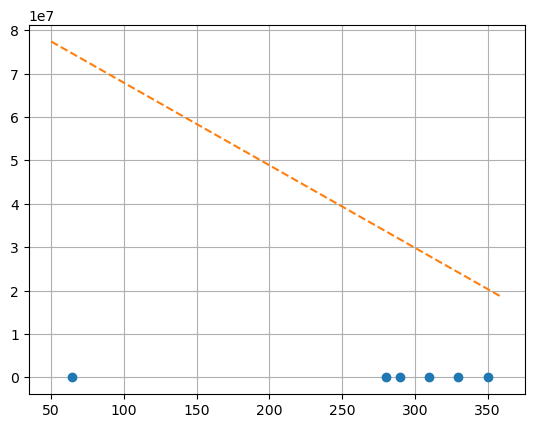

In [41]:
xs = np.linspace(50,360)

ys = f(xs)


fig, ax = plt.subplots()


ax.plot(culture_den['light_sec'], np.log(culture_den['orig_den_ml']), 'o')
ax.plot(xs, ys, '--')
ax.grid()
plt.show()

In [19]:
slope, intercept = np.polyfit(culture_den['light_sec'],culture_den['orig_den_ml'], 1)
f = np.poly1d((slope, intercept))

In [20]:
exp_data['culture_density'] = f(exp_data['light_sec'])

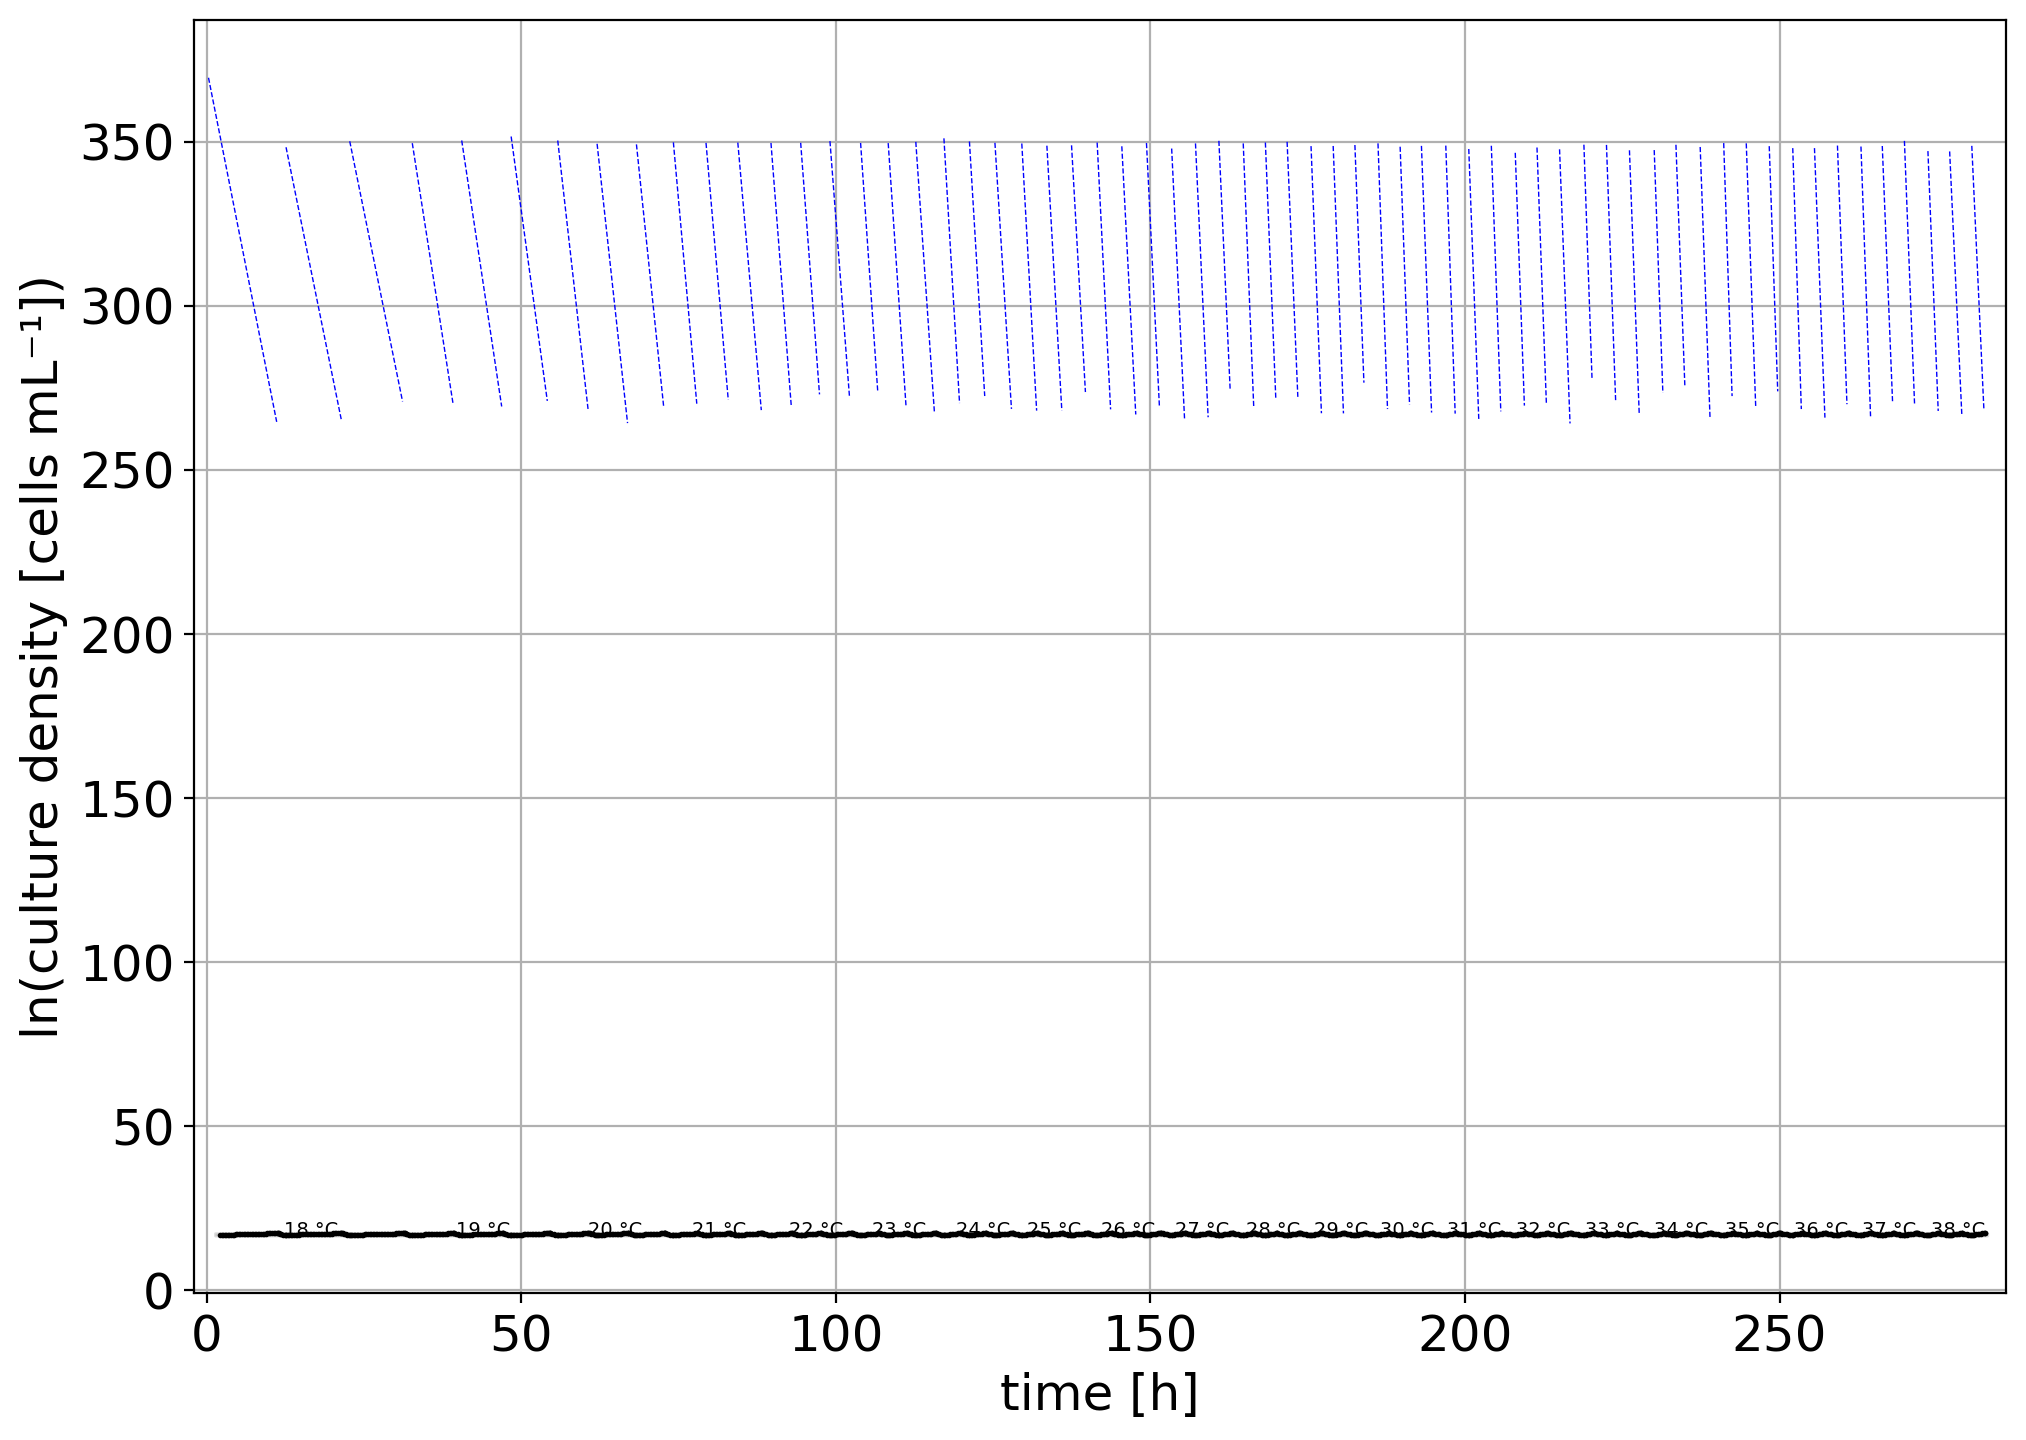

In [21]:
ys = np.log(np.arange(1.8e7, 3.75e7, 200))

fig, ax = plt.subplots(figsize=(11.69,8.27), dpi=200) #

for i in range(len(interval)-1):
    ax.fill_betweenx(ys, interval[i]+1.2, interval[i+1]+.3, alpha=.4, color='darkgrey')
    ax.text((interval[i]+((interval[i+1] - interval[i])//2)+1.5), np.log(1.9e7), f'{i+18} °C', ha='center', fontsize=7)
# sns.scatterplot(x=exp_data['total_runtime_hour'][15:], y=exp_data['light_sec'][15:], ax=ax, size=.2, color='k')
# ax.plot(exp_data['total_runtime_hour'][15:], np.log(exp_data['culture_density'][15:]), 'k', alpha=.3)
ax.plot(exp_data['total_runtime_hour'][15:], np.log(exp_data['culture_density'][15:]), 'k.', markersize=2) # lw=.8markersize=2
for k in range(len(growth_curves)):
    ax.plot(growth_curves[k][0],growth_curves[k][1], 'b--', lw=.5) 
ax.set_ylabel('ln(culture density [cells mL⁻¹])', fontsize=18)
ax.set_xlabel('time [h]', fontsize=18)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
# ax.invert_yaxis()
ax.grid()
ax.set_xlim(-2,286)
plt.savefig('sawtoothlscp.png')
# ax.legend(bbox_to_anchor=(1.01, 0.99), title='temperature')
plt.show()

In [22]:
growth_intervall = []
for i in range(len(endpts)):
    growth_data = exp_data.iloc[startpts[i]:endpts[i]]
    growth_intervall.append(growth_data)

growth_curves = {}
for j in range(len(growth_intervall)):    
    table = growth_intervall[j]
    # s = [i * 300 /60 for i in range(len(table['timestamp']))] 
    # x = [i for i in range(startpts[j],endpts[j])]
    x = table['total_runtime_hour'].values 
    y = np.log(table['culture_density'])
    slope, intercept = np.polyfit(x, y, 1)
    f = np.poly1d((slope, intercept))
    ys = f(x)
    growth_curves[j] = [x, ys, slope, intercept]
    
len(growth_curves)

63

In [23]:
# Extract slopes from growth_curves
slopes = [growth_curves[j][2] for j in range(len(growth_curves))]

if len(slopes) <(63):
    for i in range(63- len(slopes)):
        slopes.append(None)
    

# Group slopes in chunks of 3
grouped_slopes = [slopes[i:i+3] for i in range(0, len(slopes), 3)]

# Make DataFrame
df_slopes = pd.DataFrame(grouped_slopes, columns=['slope_1', 'slope_2', 'slope_3'])
df_slopes['temp'] = [i for i in range(18,39)]

df_slopes['growth_time'] = mean_growth_times + [None] * (21 - len(mean_growth_times))
df_slopes

,slope_1,slope_2,slope_3,temp,growth_time
0,0.072261,0.064913,0.065527,18,9.331389
1,0.084841,0.088667,0.097476,19,6.185185
2,0.117849,0.120637,0.128389,20,4.675278
3,0.148261,0.155513,0.150695,21,3.661481
4,0.171999,0.179130,0.176767,22,3.098611
5,0.194668,0.197204,0.192495,23,2.836296
6,0.225915,0.223747,0.214812,24,2.513056
7,0.239281,0.235164,0.238571,25,2.312315
8,0.264853,0.253733,0.273648,26,2.134167
9,0.277653,0.289867,0.303079,27,1.950185


In [24]:
n=3
# Calculate the mean of each row across the slope columns
df_slopes['mean'] = df_slopes[['slope_1', 'slope_2', 'slope_3']].mean(axis=1)
df_slopes['sd'] = df_slopes[['slope_1', 'slope_2', 'slope_3']].std(axis=1)
df_slopes['sem'] = df_slopes[['slope_1', 'slope_2', 'slope_3']].std(axis=1)/np.sqrt(n)
df_slopes['rel_err'] = df_slopes['sem'] /df_slopes['mean'] 
print(df_slopes)


     slope_1   slope_2   slope_3  temp  growth_time      mean        sd  \
0   0.072261  0.064913  0.065527    18     9.331389  0.067567  0.004077   
1   0.084841  0.088667  0.097476    19     6.185185  0.090328  0.006479   
2   0.117849  0.120637  0.128389    20     4.675278  0.122292  0.005462   
3   0.148261  0.155513  0.150695    21     3.661481  0.151490  0.003691   
4   0.171999  0.179130  0.176767    22     3.098611  0.175966  0.003632   
5   0.194668  0.197204  0.192495    23     2.836296  0.194789  0.002357   
6   0.225915  0.223747  0.214812    24     2.513056  0.221491  0.005885   
7   0.239281  0.235164  0.238571    25     2.312315  0.237672  0.002201   
8   0.264853  0.253733  0.273648    26     2.134167  0.264078  0.009980   
9   0.277653  0.289867  0.303079    27     1.950185  0.290200  0.012716   
10  0.333128  0.329380  0.319515    28     1.677778  0.327341  0.007032   
11  0.340818  0.345529  0.358742    29     1.572130  0.348363  0.009292   
12  0.376177  0.363596  0

In [25]:
df_slopes_print= df_slopes[['temp','mean', 'sd','sem','rel_err','slope_1', 'slope_2', 'slope_3', 'growth_time']].round(3)

In [26]:
df_slopes_print.columns = ['Temperature [°C]','Mean r','SD','SEM','rel SEM',' r1', 'r2', 'r3', 'growth time [h]']

In [27]:
df_slopes_print.to_csv('results.csv', index=False)

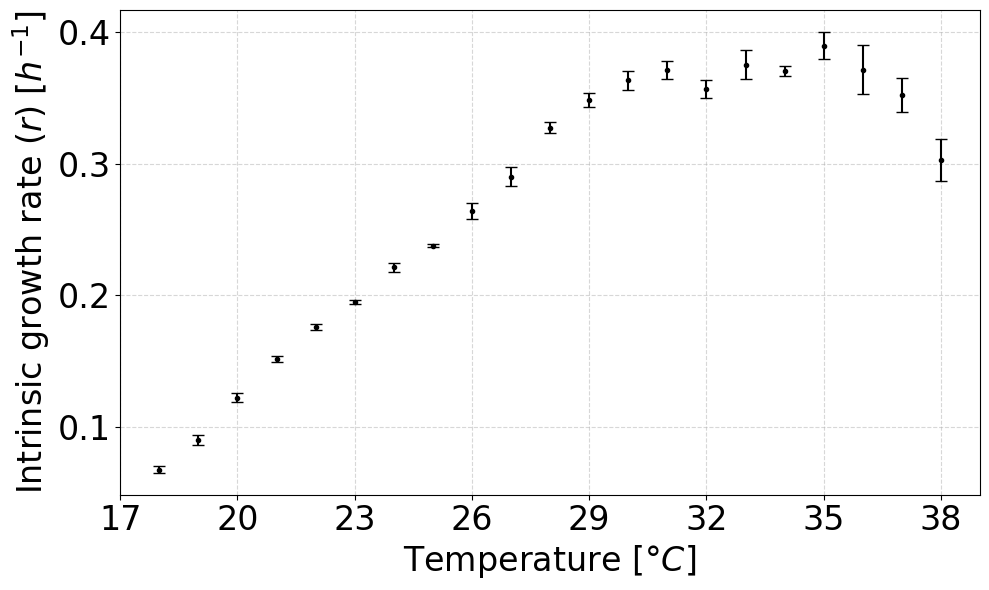

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
# plt.scatter(temperature, growth_rep1, color='blue', alpha=0.6, label='Rep 1')
# plt.scatter(temperature, growth_rep2, color='green', alpha=0.6, label='Rep 2')
# plt.scatter(temperature, growth_rep3, color='red', alpha=0.6, label='Rep 3')
# plt.text(24, 0.4, 'DUMMY DATA', color='red', size='40')
# plt.title("Microalgae Growth Rate vs Temperature")
ax.errorbar(df_slopes['temp'], df_slopes['mean'], yerr=df_slopes['sem'], markersize=3,fmt='o', capsize=4, color='black', ecolor='black', label='Mean r ± SEM')
ax.set_xlabel("Temperature [$°C$]", fontsize=24)
ax.set_ylabel("Intrinsic growth rate ($r$) $[h^{-1}]$", fontsize=24)
ax.set_xticks(np.arange(17, 39,3))
ax.grid(True, linestyle='--', alpha=0.5)
# ax.legend()
# ax.invert_yaxis()
ax.xaxis.set_tick_params(labelsize=24)
ax.yaxis.set_tick_params(labelsize=24)
plt.tight_layout()
plt.show()


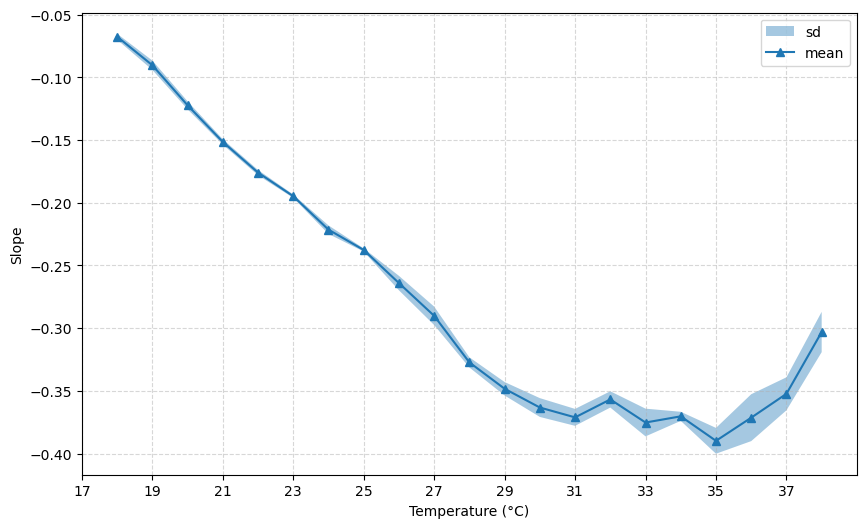

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.fill_between(df_slopes['temp'], -df_slopes['mean']-df_slopes['sem'], -df_slopes['mean']+df_slopes['sem'], alpha=0.4, label='sd')
ax.plot(df_slopes['temp'], -df_slopes['mean'],'^-', label='mean' )
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Slope")
ax.set_xticks(np.arange(17, 39, 2))
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.show()

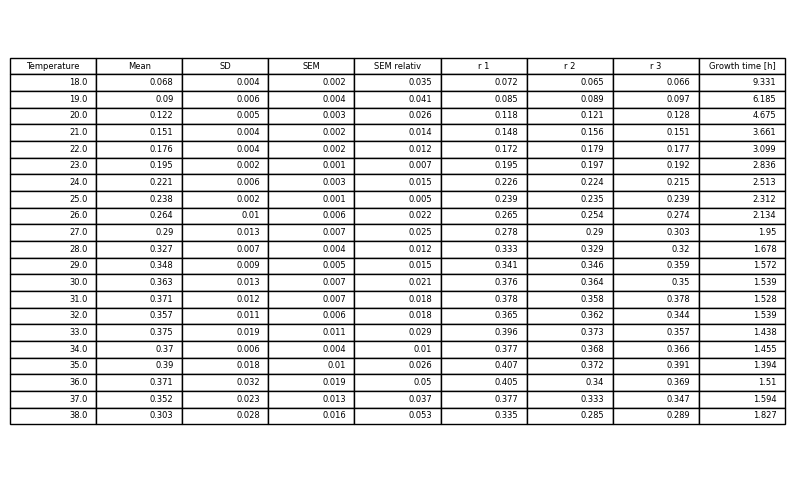

In [30]:
fig, ax = plt.subplots(figsize=(10,6))

ax.table(cellText=np.abs(df_slopes[['temp','mean', 'sd','sem','rel_err','slope_1', 'slope_2', 'slope_3', 'growth_time']].round(3).values),
            colLabels=['Temperature','Mean', 'SD','SEM','SEM relativ','r 1', 'r 2', 'r 3', 'Growth time [h]'], 
            loc='center')
ax.set_axis_off()

plt.show()

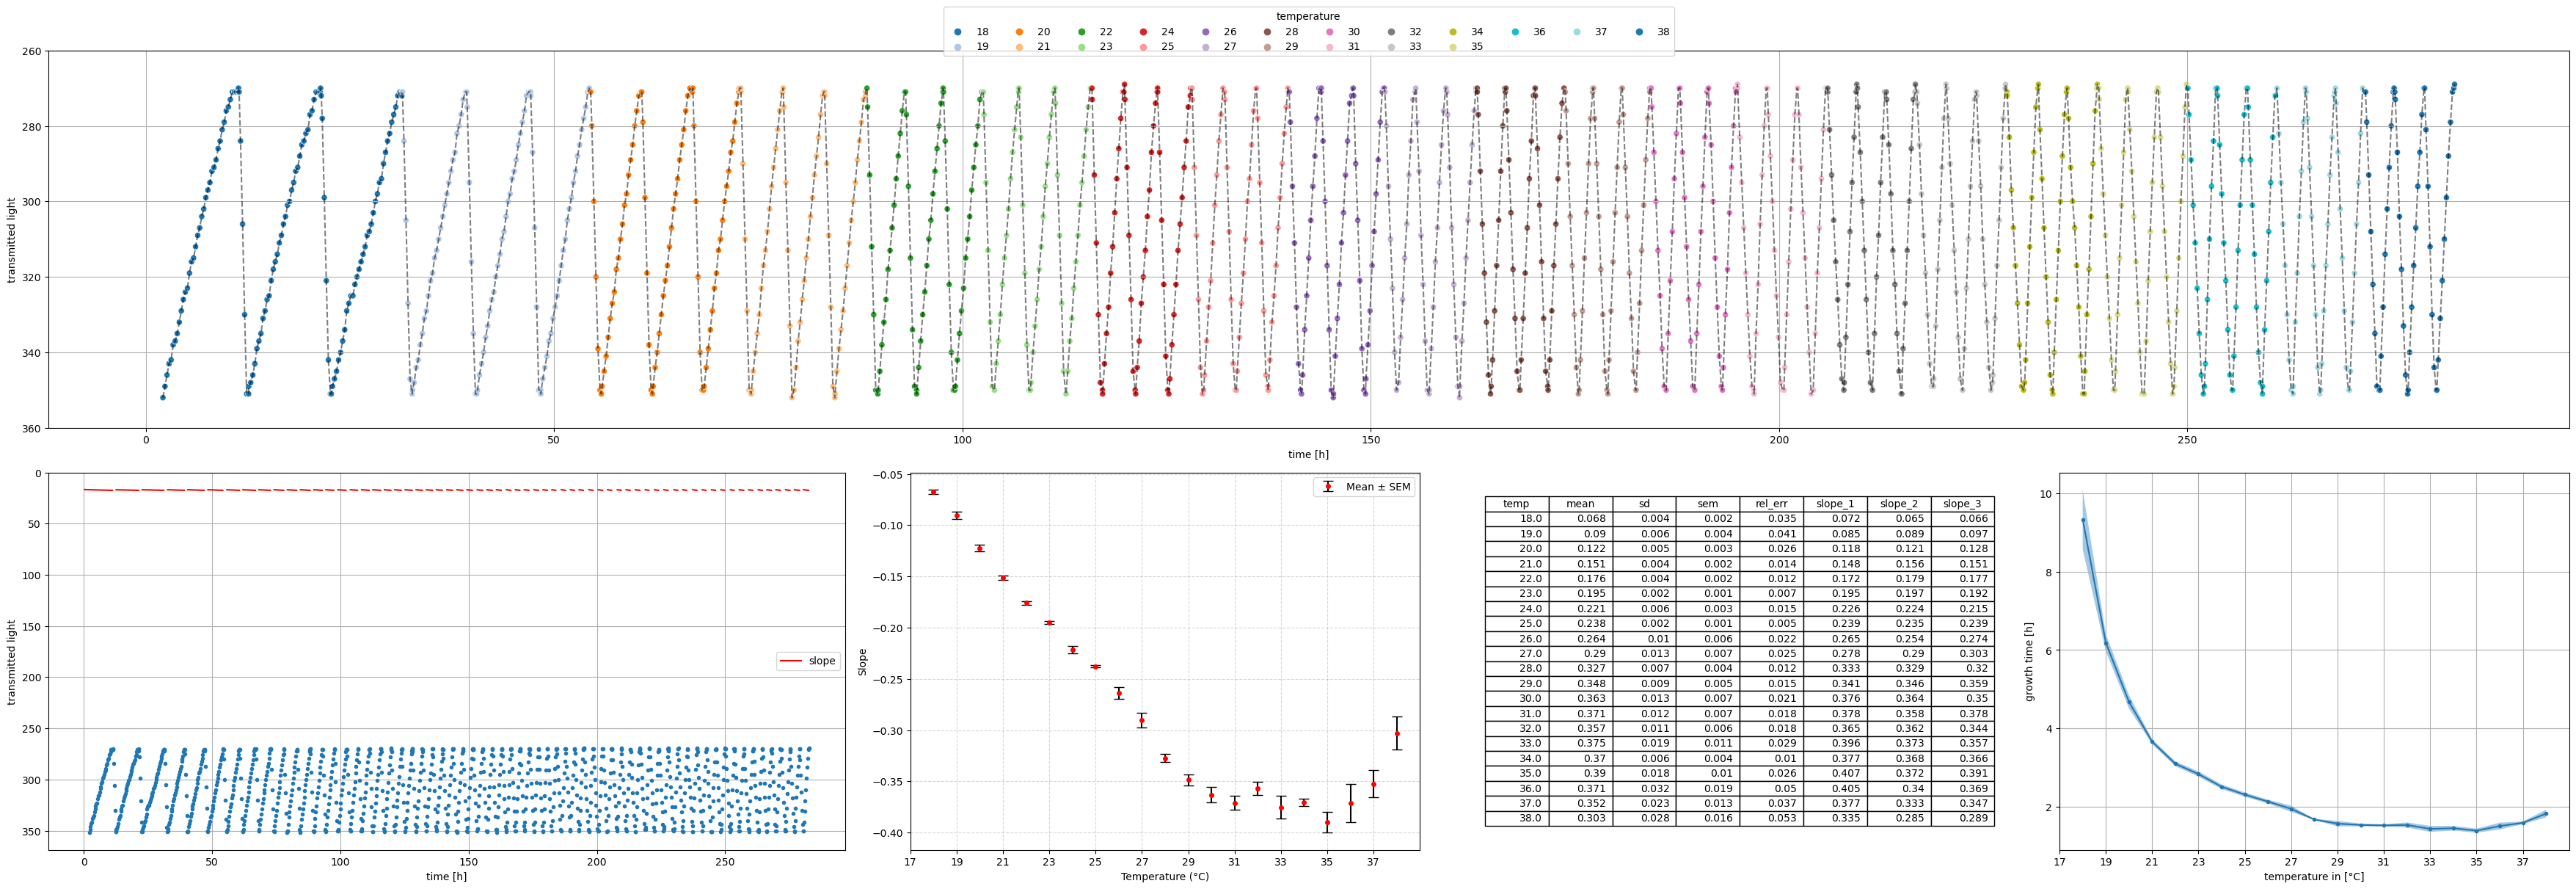

In [31]:
ax = plt.figure(layout='constrained', figsize=(35,12)).subplot_mosaic("""
                                                    AAAAAAAAA
                                                    BBBCCDDEE
                                                    """)

ax['A'].plot(exp_data['total_runtime_hour'][15:], exp_data['light_sec'][15:], 'k--', alpha=.5)
sns.scatterplot(x=exp_data['total_runtime_hour'][15:], y=exp_data['light_sec'][15:], hue=exp_data[15:]['exp_temp'], ax=ax['A'], palette='tab20')
ax['A'].set_ylabel('transmitted light')
ax['A'].set_xlabel('time [h]')
ax['A'].set_ylim(260,360)
ax['A'].invert_yaxis()
ax['A'].grid()
ax['A'].legend(bbox_to_anchor=(.5, 1.05), title='temperature', ncol=len(exp_data['exp_temp'].unique())//2, loc='center')

for k in range(len(growth_curves)):
    ax['B'].plot(growth_curves[k][0],growth_curves[k][1], 'r', label='slope')
    # ax.text(exp_data['total_runtime_hour'].iloc[growth_curves[k][0][0]], 94, f'slope :{growth_curves[k][2]:.2f}\ninter: {growth_curves[k][3]:.2f}', color='red')
    if k==0:
        ax['B'].legend()
ax['B'].plot(exp_data['total_runtime_hour'][15:], exp_data['light_sec'][15:], '.')
ax['B'].set_ylabel('transmitted light')
ax['B'].set_xlabel('time [h]')
ax['B'].invert_yaxis()
ax['B'].grid()


ax['C'].errorbar(df_slopes['temp'], -df_slopes['mean'], yerr=df_slopes['sem'], markersize=4,fmt='o', capsize=5, color='red', ecolor='black', label='Mean ± SEM')
ax['C'].set_xlabel("Temperature (°C)")
ax['C'].set_ylabel("Slope")
ax['C'].set_xticks(np.arange(17, 39, 2))
ax['C'].grid(True, linestyle='--', alpha=0.5)
ax['C'].legend()

ax['D'].table(cellText=np.abs(df_slopes[['temp','mean', 'sd','sem','rel_err','slope_1', 'slope_2', 'slope_3']].round(3).values),
            colLabels=['temp','mean', 'sd','sem','rel_err','slope_1', 'slope_2', 'slope_3'], 
            loc='center')
ax['D'].set_axis_off()


ax['E'].fill_between([x +18 for x in range(len(mean_growth_times))],
                [mean_growth_times[i]-sem_growth_times[i] for i in range(len(mean_growth_times))],
                [mean_growth_times[i]+sem_growth_times[i] for i in range(len(mean_growth_times))],
                alpha=0.4,
                label='SEM')
ax['E'].plot([x +18 for x in range(len(mean_growth_times))], mean_growth_times, '.-')
ax['E'].grid()
ax['E'].set_ylabel('growth time [h]')
ax['E'].set_xlabel('temperature in [°C]')
ax['E'].set_xticks(np.arange(17, 39, 2))


# plt.tight_layout()
plt.show()

In [32]:
46.9 / 9.5

4.936842105263158

In [33]:
# df_Q10_mean = pd.DataFrame()
# df_Q10_mean['temp_start'] = df_slopes['temp'][:-1].values  # start temp for each Q10

# Q10_list = []
# for i in range(len(df_slopes) - 1):
#     R1 = np.abs(df_slopes.loc[i, 'mean'])
#     R2 = np.abs(df_slopes.loc[i+1, 'mean'])
#     T1 = df_slopes.loc[i, 'temp']
#     T2 = df_slopes.loc[i+1, 'temp']

#     if R1 is not None and R2 is not None and R1 > 0 and R2 > 0:
#         Q10 = (R2 / R1) ** (10 / (T2 - T1))
#     else:
#         Q10 = np.nan  # handle missing or zero slopes
#     Q10_list.append(Q10)

# df_Q10_mean['Q10_mean_slope'] = Q10_list

df_Q10_mean

NameError: name 'df_Q10_mean' is not defined

In [ ]:
2271/24

94.625